# k-means-finding-centers

In [79]:
from pylab import mpl
from collections import defaultdict
import re
import math
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

In [80]:
mpl.rcParams['font.sans-serif']  = ['Arial Unicode MS']
mpl.rcParams['axes.unicode_minus'] = False

In [82]:
coordination_source = """
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

In [84]:
## Feacutre Extractor
city_location = {
    '香港': (114,17, 22.28)
}


test_string = "{name:'兰州‘, geoCoord:[103.73, 36.03]},"


pattern = re.compile(r"name:'(\w+)',\s+geoCoord:\[(\d+.\d+),\s(\d+.\d+)\]")

for line in coordination_source.split('\n'):
    
    city_info = pattern.findall(line)

    if not city_info: continue

    # following: we find the city info

    city, long, lat = city_info[0]

    long, lat = float(long), float(lat)

    city_location[city] = (long, lat)

city_location


{'香港': (114.17, 22.28),
 '贵阳': (106.71, 26.57),
 '武汉': (114.31, 30.52),
 '郑州': (113.65, 34.76),
 '济南': (117.0, 36.65),
 '南京': (118.78, 32.04),
 '合肥': (117.27, 31.86),
 '杭州': (120.19, 30.26),
 '南昌': (115.89, 28.68),
 '福州': (119.3, 26.08),
 '广州': (113.23, 23.16),
 '长沙': (113.0, 28.21),
 '海口': (110.35, 20.02),
 '沈阳': (123.38, 41.8),
 '长春': (125.35, 43.88),
 '哈尔滨': (126.63, 45.75),
 '太原': (112.53, 37.87),
 '西安': (108.95, 34.27),
 '台湾': (121.3, 25.03),
 '北京': (116.46, 39.92),
 '上海': (121.48, 31.22),
 '重庆': (106.54, 29.59),
 '天津': (117.2, 39.13),
 '呼和浩特': (111.65, 40.82),
 '南宁': (108.33, 22.84),
 '西藏': (91.11, 29.97),
 '银川': (106.27, 38.47),
 '乌鲁木齐': (87.68, 43.77),
 '澳门': (113.54, 22.19)}

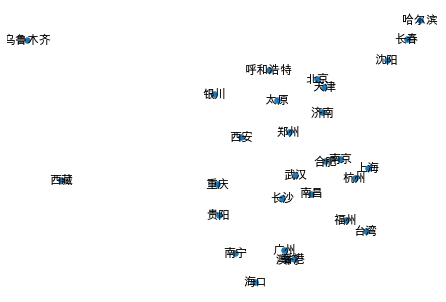

In [86]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ------------
    origin: tuple of float
        (lat, long)
    destination: tuple of float
        (lat, long)
    
    Returns
    --------

    distance_in_km: float

    Examples
    ---------
    >>> origin = (48.1372, 11.5756) # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
        math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    print(d)
    return d

%matplotlib inline

city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_location.keys()))
nx.draw(city_graph, city_location, with_labels=True, node_size = 30)

In [87]:
k = 10

all_x = []
all_y = []

for _, location in city_location.items():
    x, y = location

    all_x.append(x)
    all_y.append(y)


def get_random_center(all_x, all_y):
    r_x = random.uniform(min(all_x), max(all_y))
    r_y = random.uniform(min(all_y), max(all_y))

    return r_x, r_y


get_random_center(all_x, all_y)


K = 5
centers = {'{}'.format(i+1):get_random_center(all_x, all_y) for i in range(K)}

closet_points = defaultdict(list)

for x, y in zip(all_x, all_y):
    closet_c, closet_dis = min([(k, geo_distance((x,y), centers[k])) for k in centers], key=lambda t: t[1])

    closet_points[closet_c].append([x,y])


def iterate_once(centers, closet_points, threshold = 5):
    have_changed = False

    for c in closet_points:
        former_center = centers[c]

        neighbors =closet_points[c]

        neighbors_center = np.mean(neighbors, axis = 0)

        if geo_distance(neighbors_center, former_center) > threshold:
            centers[c] = neighbors_center
            have_changed = True
        else:
            pass ## keep former center

    return centers, have_changed

6024.903717180583
4800.749804563061
5492.091174559206
6296.67583269914
4385.08141437176
5132.7391443241695
3908.2086108166
4669.66654504427
5403.884246143936
3505.4424376338307
5596.616039696108
4333.651102266097
5365.975700565605
5848.0193146718975
3823.964439274635
5347.414629397919
4079.2773311385254
5278.456261003324
5585.740528291824
3525.260215723278
5548.541683446628
4283.793479201793
5576.640368660368
5775.531683580727
3697.7218519147837
5905.509816258731
4637.529285693581
5772.388650986523
6146.264119661317
4088.869633501683
5785.764814697199
4518.324318257353
5632.598258579081
6029.135511516158
3978.531089916765
6113.992985038209
4846.89029285045
5929.512487154911
6358.312310695462
4308.677033922862
5824.956110432054
4565.174295740541
5540.377114578458
6079.586141983622
4066.490489339132
6258.867648317974
5001.910444277176
5918.480412979653
6515.8538290658735
4509.271548546496
5891.76829293588
4665.587757891776
5377.673918314606
6162.859003414151
4247.884395878514
5598.153458

In [88]:
def kmeans(Xs, k, threshold = 5):
    all_x = Xs[:, 0]
    all_y = Xs[:, 1]

    K = k

    centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}

    changed = True

    while changed:
        closet_points = defaultdict(list)

        for x, y, in zip(all_x, all_y):
            closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])
            closet_points[closet_c].append([x, y])

        centers, changed = iterate_once(centers, closet_points, threshold)
        print('iteration')
    return centers

kmeans(np.array(list(city_location.values())), k=5,threshold=5)

4047.7840816344747
4441.321371408573
5443.658004213405
3600.8835962285443
4526.169406715818
3177.0887592919594
3548.4066230436288
4587.645862589683
2839.741695697209
3761.5116015569743
3796.6556490155426
3995.5693870881973
5223.376007592858
3625.1543116825133
4532.048986976009
3671.247484291479
3758.5307047135516
5088.331461339246
3651.1669908309495
4527.510675232267
3958.6190498705832
3978.3323325145598
5363.757820253976
3995.5069682294743
4860.26845908716
4182.7877296181205
4312.615919238332
5606.819455197855
4066.797125209389
4967.095683286484
4046.133241479512
4190.197835770891
5471.018635600778
3922.9679822562207
4823.641663521513
4354.25436234336
4517.243161870404
5780.561123133351
4184.310728548342
5094.174825711305
3990.2419392707807
4223.206594201951
5416.007800405308
3758.7759264156234
4674.712694072756
4393.245919257891
4657.321264739624
5815.423416613318
4092.2910154359965
5015.626396593237
3921.9810255075718
4306.6215311843
5321.857207898831
3496.2946860902953
4422.1886496

{'1': array([116.73818182,  30.26636364]),
 '2': array([114.415,  40.806]),
 '3': (60.041774809271416, 27.92140107530695),
 '4': array([107.9975,  24.5775]),
 '5': (70.4360152889741, 20.053109628513614)}

{'能源站-1': (53.02037574117802, 37.838320581868985),
 '能源站-2': (67.42117240929971, 40.063271715187106),
 '能源站-3': (60.27397046342716, 23.35612187426721),
 '能源站-4': (49.856868579015874, 38.70937367520111),
 '能源站-5': (73.94012476018047, 43.79339793127472)}

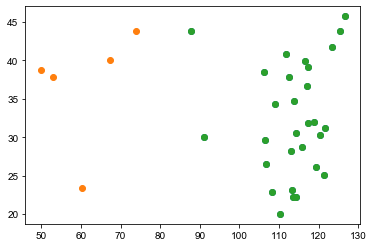

In [90]:
plt.scatter(all_x, all_y)

plt.scatter(*zip(*centers.values()))

for c, points in closet_points.items():
    plt.scatter(*zip(*points))


city_location_with_station = {
    '能源站-{}'.format(i): position for i, position in centers.items()
}
city_location_with_station

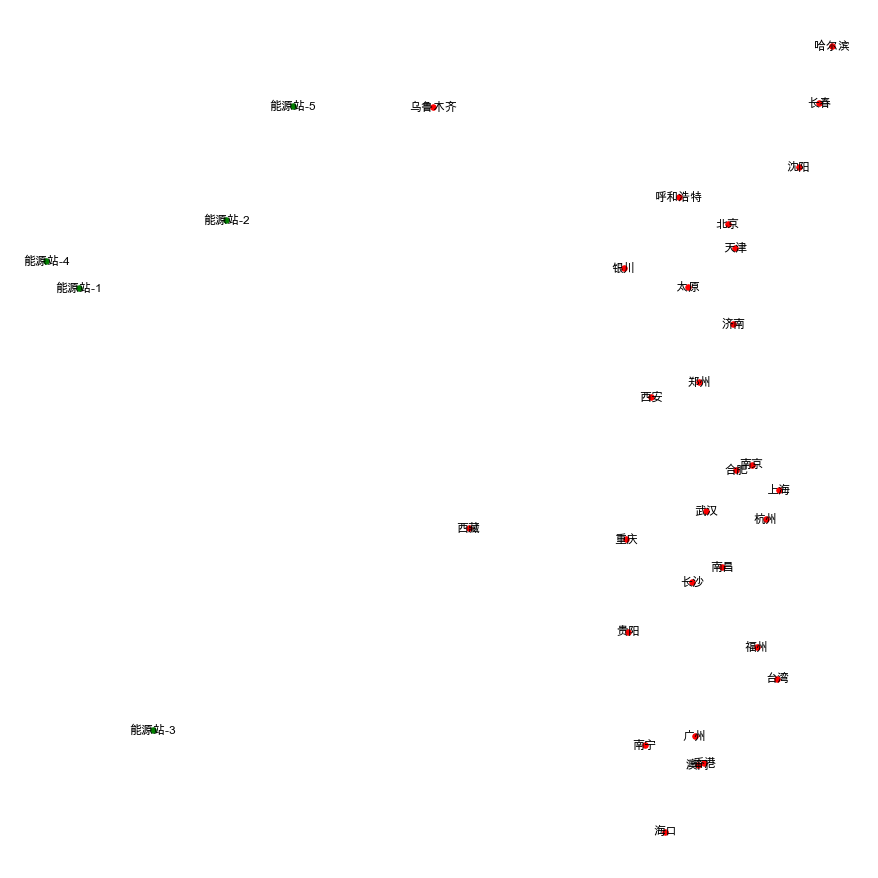

In [91]:
def draw_cities(citise, color = None):
    city_graph = nx.Graph()
    city_graph.add_nodes_from(list(citise.keys()))
    nx.draw(city_graph, citise, node_color = color, with_labels=True, node_size = 30)
%matplotlib inline


plt.figure(figsize = (12, 12))
draw_cities(city_location_with_station, color = 'green')
draw_cities(city_location, color = 'red')

# k-means-clustering-of-1-million-headlines

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


data = pd.read_csv("./data/abcnews-date-text.csv",error_bad_lines=False,usecols =["headline_text"])
data.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [5]:
data.to_csv('abcnews.csv', index=False, encoding='utf8')

data.info()